In [1]:
import torch
import os
import h5py
import pandas as pd
import numpy as np
import shutil
from sklearn.model_selection import train_test_split
from utils.PathDataset import Pathology_Dataset_test
from torch.utils.data import Dataset, DataLoader
from utils.T1Dataset import T1Dataset_regression_mr_path_test
from models.SENet import Model_path_mr
from lifelines.utils import concordance_index
from models.MLP import MLP
import torch
import torchtuples as tt
from utils.img_processing import convert_path,normalize_min_max
from pycox.datasets import metabric
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv
import matplotlib.pyplot as plt

In [7]:
df = pd.read_csv('G:\glioma\\final_data\glioma_survive\\5hmc\huashan_5hmc_.csv')
df

,patient,score_gene,score,IDH,WHO,Age,Gender,survival_month,status_dead
0,Pan_Jing_Wei,0.457889,0.186934,0,4,36.0,1,27.13,1
1,Geng_Xin,0.469941,0.318546,1,4,28.0,0,35.30,1
2,Wu_Jing_Zhen,0.460363,0.820950,1,3,60.0,0,69.53,0
3,Xin_Wen,0.797674,0.225211,0,2,33.0,0,69.47,0
4,Zhang_Guo_Wei,0.641296,0.252710,1,2,30.0,1,66.63,0
5,Qin_Mei_Hua,0.449362,0.091404,0,2,30.0,1,53.47,1
6,Ling_Yan_Rong,0.496287,0.199656,0,4,51.0,1,20.87,1
7,Zhuang_Zi_Ming,0.616854,0.369815,1,2,32.0,1,66.20,0
8,Huang_Xue_Yu,0.285971,0.320955,0,4,49.0,0,17.97,1
9,Shen_Lin_Jia,0.113935,0.299568,0,4,72.0,0,9.73,1


In [25]:
df.head(1)

,patient,score_gene,score,IDH,WHO,Age,Gender,survival_month,status_dead
0,Pan_Jing_Wei,0.457889,0.186934,0,4,36.0,1,27.13,1


In [8]:
df_train_, df_test, y_train, y_test = train_test_split(df,df['patient'],test_size=0.2,random_state=201)
df_train, df_val, y_train, y_test = train_test_split(df_train_,df_train_['patient'],test_size=0.2,random_state=2018)
df_train_[['WHO','Age','Gender','IDH','score_gene']] = df_train_[['WHO','Age','Gender','IDH','score_gene']].astype('float32')
get_target = lambda df_train_: (df_train_['survival_month'].values, df_train_['status_dead'].values)
y_train = get_target(df_train_)
train_feature = df_train_[['WHO','Age','Gender','IDH','score_gene']].values

df_test[['WHO','Age','Gender','IDH','score_gene']] = df_test[['WHO','Age','Gender','IDH','score_gene']].astype('float32')
val_feature = df_test[['WHO','Age','Gender','IDH','score_gene']].values
get_target = lambda df_test: (df_test['survival_month'].values, df_test['status_dead'].values)
y_val = get_target(df_test)
val = tt.tuplefy(val_feature, y_val)

def calculate_param(df_TCGA_loc_M, model_cph1):
    df_TCGA_loc_M[['WHO','Age','Gender','IDH','score_gene']] = df_TCGA_loc_M[['WHO','Age','Gender','IDH','score_gene']].astype('float32')
    feature_TCGA_loc_M = df_TCGA_loc_M[['WHO','Age','Gender','IDH','score_gene']].values
    get_target = lambda df_TCGA_loc_M: (df_TCGA_loc_M['survival_month'].values, df_TCGA_loc_M['status_dead'].values)
    durations_test_ex, events_test_ex = get_target(df_TCGA_loc_M)
    _ = model_cph1.compute_baseline_hazards()
    surv = model_cph1.predict_surv_df(feature_TCGA_loc_M)
    ev = EvalSurv(surv, durations_test_ex, events_test_ex, censor_surv='km')
    time_grid = np.linspace(durations_test_ex.min(), durations_test_ex.max(), 100)
    return ev.concordance_td(),ev.integrated_brier_score(time_grid)

0:	[0s / 0s],		train_loss: 1.6962,	val_loss: 1.2974
1:	[0s / 0s],		train_loss: 1.6253,	val_loss: 1.2370
2:	[0s / 0s],		train_loss: 1.5971,	val_loss: 1.4041
3:	[0s / 0s],		train_loss: 1.5428,	val_loss: 1.2616
4:	[0s / 0s],		train_loss: 1.6309,	val_loss: 1.0666
5:	[0s / 0s],		train_loss: 1.7427,	val_loss: 1.0686
6:	[0s / 0s],		train_loss: 1.7397,	val_loss: 1.0907
7:	[0s / 0s],		train_loss: 1.5343,	val_loss: 1.1177
8:	[0s / 0s],		train_loss: 1.5475,	val_loss: 1.1632
9:	[0s / 0s],		train_loss: 1.4194,	val_loss: 1.1443
10:	[0s / 0s],		train_loss: 1.6094,	val_loss: 1.1251
11:	[0s / 0s],		train_loss: 1.4965,	val_loss: 1.0966
12:	[0s / 0s],		train_loss: 1.3618,	val_loss: 1.0269
13:	[0s / 0s],		train_loss: 1.5050,	val_loss: 1.0246
14:	[0s / 0s],		train_loss: 1.3366,	val_loss: 1.0227
15:	[0s / 0s],		train_loss: 1.5251,	val_loss: 0.9983
16:	[0s / 0s],		train_loss: 1.4295,	val_loss: 0.9487
17:	[0s / 0s],		train_loss: 1.5277,	val_loss: 0.9583
18:	[0s / 0s],		train_loss: 1.4808,	val_loss: 0.8780
19:

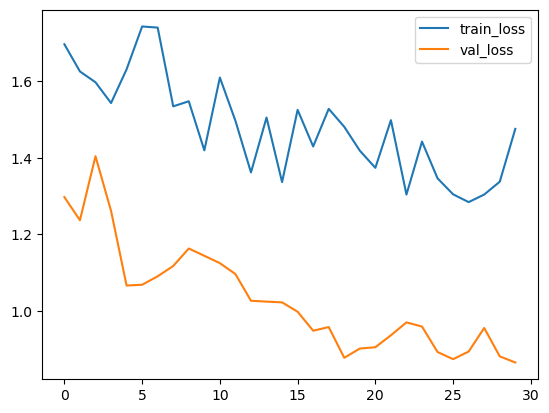

In [9]:
in_features = train_feature.shape[1]
num_nodes = [32, 32]
out_features = 1
batch_norm = True
dropout = 0.1
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)
model_cph = CoxPH(net, tt.optim.Adam)
batch_size = 10
lrfinder = model_cph.lr_finder(train_feature, y_train, batch_size, tolerance=10)
# _ = lrfinder.plot()
model_cph.optimizer.set_lr(lrfinder.get_best_lr())
epochs = 30
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True
log = model_cph.fit(train_feature, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)
_ = log.plot()

In [11]:
print("MM-CoxPH Mutil-Modal-B")
print("Huashan-Test-Set (c-index, brier scores)",calculate_param(df_test,model_cph))

MM-CoxPH Mutil-Modal-B
Huashan-Test-Set (c-index, brier scores) (0.8431372549019608, 0.15956368417996994)


In [12]:
model_cph.save_net(os.path.join('G:\glioma\\final_data\glioma_survive\\5hmc\pth','MM-CoxPH Mutil-Modal-B.pth'))